In [13]:
# generated by Chat GPT: Import required modules and set device
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# generated by Chat GPT: Set device to use MPS if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: mps


In [42]:
# generated by Chat GPT: Define WeatherDataset and create DataLoader
class WeatherDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.transform = transform
        # Search recursively for jpg images
        self.image_paths = glob.glob(os.path.join(root_dir, '**/*.jpg'), recursive=True)
        print(f"Found {len(self.image_paths)} images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('RGB', (32, 32), (0, 0, 0))
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations: resize to 32x32, convert to tensor, normalize to [-1,1]
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Set dataset root and create DataLoader.
dataset_root = "./archive"
weather_dataset = WeatherDataset(root_dir=dataset_root, transform=transform)
batch_size = 128
dataloader = DataLoader(weather_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


Found 819 images.


In [43]:
# generated by Chat GPT: Define diffusion schedule and helper function
T = 1000  # total diffusion steps
betas = torch.linspace(1e-4, 0.02, T).to(device)  # linear schedule from 1e-4 to 0.02
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)  # cumulative product, shape (T,)

def q_sample(x0, t, noise=None):
    """
    Diffuse the data (forward process).
    Args:
        x0: original images, shape (B, 3, 32, 32)
        t: timestep tensor of shape (B,) with integer timesteps in [0, T-1]
        noise: optional noise tensor; if None, noise is sampled
    Returns:
        x_t: Noisy images at timestep t.
    """
    if noise is None:
        noise = torch.randn_like(x0)
    # Gather the corresponding alpha_bar for each t and reshape for broadcasting
    sqrt_alpha_bar = alpha_bars[t].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar = (1 - alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
    return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise


In [44]:
# generated by Chat GPT: Define a transformer-based denoiser for diffusion (updated)
class DiffusionTransformer(nn.Module):
    def __init__(self, image_size=32, patch_size=4, in_channels=3, embed_dim=256, num_layers=6, num_heads=8, dropout=0.1):
        super(DiffusionTransformer, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels  # store in_channels as an attribute
        self.num_tokens = (image_size // patch_size) ** 2  # e.g. 8x8 = 64 patches
        self.embed_dim = embed_dim

        # Patch embedding: converts image into patches
        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        # Positional embeddings for tokens
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, embed_dim))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Time embedding: simple MLP to project timestep scalar to embed_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

        # Projection from transformer tokens back to patch pixels (predicting noise)
        self.to_patch = nn.Linear(embed_dim, patch_size * patch_size * in_channels)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, t):
        """
        Args:
            x: Noisy images, shape (B, 3, image_size, image_size)
            t: Timestep tensor, shape (B,) with integer timesteps
        Returns:
            Predicted noise, shape (B, 3, image_size, image_size)
        """
        B = x.shape[0]
        # Convert image to patch tokens
        x = self.patch_embed(x)              # shape: (B, embed_dim, H/patch, W/patch)
        x = x.flatten(2).transpose(1, 2)       # shape: (B, num_tokens, embed_dim)
        x = x + self.pos_embed                # add positional embedding

        # Process timestep: convert integer t to a float tensor and project
        t = t.view(B, 1).float()
        t_emb = self.time_mlp(t)              # shape: (B, embed_dim)
        x = x + t_emb.unsqueeze(1)            # add time embedding to each token

        # Transformer expects shape (num_tokens, B, embed_dim)
        x = x.transpose(0, 1)
        x = self.transformer(x)
        x = x.transpose(0, 1)                 # back to (B, num_tokens, embed_dim)

        # Project tokens back to patch pixels (predict noise)
        x = self.to_patch(x)  # shape: (B, num_tokens, patch_size*patch_size*in_channels)

        # Reshape tokens to image patches then reassemble to full image
        x = x.view(B, self.num_tokens, self.in_channels, self.patch_size, self.patch_size)
        grid_size = self.image_size // self.patch_size
        x = x.view(B, grid_size, grid_size, self.in_channels, self.patch_size, self.patch_size)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()
        x = x.view(B, self.in_channels, self.image_size, self.image_size)
        return x


In [45]:
# generated by Chat GPT: Instantiate the diffusion transformer model, loss, and optimizer
lr =.0002

diffusion_model = DiffusionTransformer(image_size=32, patch_size=4, in_channels=3, embed_dim=256, num_layers=12, num_heads=8).to(device)
optimizer_diffusion = optim.Adam(diffusion_model.parameters(), lr=lr)
mse_loss = nn.MSELoss()


In [46]:
# generated by Chat GPT: Training loop for the diffusion transformer model
num_epochs_diffusion = 100  # Adjust epochs as needed

diffusion_model.train()
for epoch in range(num_epochs_diffusion):
    epoch_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)  # batch shape: (B, 3, 32, 32)
        B = batch.size(0)
        # Sample random timesteps for each image in the batch
        t = torch.randint(0, T, (B,), device=device, dtype=torch.long)
        # Sample random noise to add
        noise = torch.randn_like(batch)
        # Generate noisy images at timestep t
        x_t = q_sample(batch, t, noise)
        # Predict noise using the diffusion transformer model
        predicted_noise = diffusion_model(x_t, t)
        # Compute loss (MSE between predicted noise and true noise)
        loss = mse_loss(predicted_noise, noise)

        optimizer_diffusion.zero_grad()
        loss.backward()
        optimizer_diffusion.step()

        epoch_loss += loss.item() * B

    avg_loss = epoch_loss / len(weather_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs_diffusion}], Loss: {avg_loss:.4f}")


Epoch [1/100], Loss: 1.8083
Epoch [2/100], Loss: 1.1403
Epoch [3/100], Loss: 1.1071
Epoch [4/100], Loss: 1.0955
Epoch [5/100], Loss: 1.0882
Epoch [6/100], Loss: 1.0824
Epoch [7/100], Loss: 1.0804
Epoch [8/100], Loss: 1.0765
Epoch [9/100], Loss: 1.0728
Epoch [10/100], Loss: 1.0723
Epoch [11/100], Loss: 1.0689
Epoch [12/100], Loss: 1.0664
Epoch [13/100], Loss: 1.0620
Epoch [14/100], Loss: 1.0585
Epoch [15/100], Loss: 1.0570
Epoch [16/100], Loss: 1.0541
Epoch [17/100], Loss: 1.0507
Epoch [18/100], Loss: 1.0511
Epoch [19/100], Loss: 1.0496
Epoch [20/100], Loss: 1.0451
Epoch [21/100], Loss: 1.0443
Epoch [22/100], Loss: 1.0418
Epoch [23/100], Loss: 1.0381
Epoch [24/100], Loss: 1.0364
Epoch [25/100], Loss: 1.0358
Epoch [26/100], Loss: 1.0334
Epoch [27/100], Loss: 1.0322
Epoch [28/100], Loss: 1.0299
Epoch [29/100], Loss: 1.0305
Epoch [30/100], Loss: 1.0276
Epoch [31/100], Loss: 1.0284
Epoch [32/100], Loss: 1.0278
Epoch [33/100], Loss: 1.0261
Epoch [34/100], Loss: 1.0247
Epoch [35/100], Loss: 1

In [47]:
# generated by Chat GPT: Save the trained diffusion model checkpoint to file
checkpoint_path = "diffusion_model_checkpoint.pth"
torch.save(diffusion_model.state_dict(), checkpoint_path)
print(f"Saved diffusion model checkpoint to {checkpoint_path}")


Saved diffusion model checkpoint to diffusion_model_checkpoint.pth


Saved generated images to generated_images.png


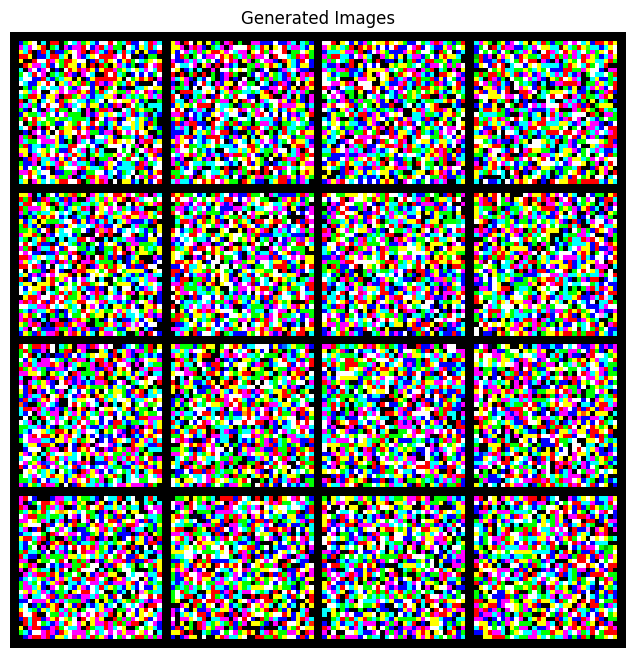

In [48]:
# generated by Chat GPT: Generate images via reverse diffusion and save them to file
import torchvision.utils as vutils

@torch.no_grad()
def p_sample(model, x, t):
    """
    One reverse diffusion (denoising) step.
    Args:
        model: The trained diffusion transformer.
        x: Current noisy image, shape (B, 3, 32, 32)
        t: Current timestep (int)
    Returns:
        x_prev: Denoised image at previous timestep.
    """
    B = x.shape[0]
    t_tensor = torch.full((B,), t, device=device, dtype=torch.long)
    predicted_noise = model(x, t_tensor)
    beta_t = betas[t]
    alpha_t = alphas[t]
    alpha_bar_t = alpha_bars[t]
    # Compute coefficients following DDPM update rule
    if t > 0:
        noise = torch.randn_like(x)
    else:
        noise = 0
    sigma_t = beta_t.sqrt()
    x_prev = 1/alpha_t.sqrt() * (x - (beta_t / (1 - alpha_bar_t).sqrt()) * predicted_noise) + sigma_t * noise
    return x_prev

@torch.no_grad()
def sample_image(model, shape):
    """
    Generate an image by iteratively denoising starting from random noise.
    Args:
        model: The trained diffusion transformer.
        shape: Shape of the image to generate (B, 3, 32, 32)
    Returns:
        x: Generated image tensor.
    """
    x = torch.randn(shape, device=device)
    for t in reversed(range(T)):
        x = p_sample(model, x, t)
    return x

# Set model to evaluation mode and generate images
diffusion_model.eval()
generated = sample_image(diffusion_model, (16, 3, 32, 32))  # generate 16 images

# Denormalize images from [-1,1] to [0,1] for saving and display
generated = (generated + 1) / 2
generated = generated.clamp(0, 1).cpu()

# Save generated images to a file
save_path = "generated_images.png"
vutils.save_image(generated, save_path, nrow=4)
print(f"Saved generated images to {save_path}")

# Display the generated images
grid = vutils.make_grid(generated, nrow=4)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title("Generated Images")
plt.show()
